shufflenetV2发表于2018年，其贡献是指出现在大多数轻量级模型都是用计算量这样非直接的评价指标，如FLOPs，但应该用直接的指标，也是就速度（speed）。Speed不只与计算量有关，还与内存、平台特性有关系。此外，对shufflenetV1进行改进，提出一种新的轻量级模型shufflenetV2.
现在大多数模型用FLOPs作为评价指标，但这是非直接的指标，相同的计算量下，可能速度有较大差异。因此应该用直接指标，如speed或latency。

除了计算量以外，影响速度的因素主要有两个：内存访问耗时(memory access cost, MAC)与平台的并行程度。

此外，还要考虑其它平台特性。如cudnn针对3x3卷积进行了大量优化，不能简单认为3x3卷积比1x1卷积慢9倍。

因此，本文提出两个原则：1)应该采用直接的指标；2)评价应该根据实际的平台特性。

在GPU与ARM上对mobilenet与shufflenetV1进行了测试，结果如下图。可以看出，除了卷积之外，其它操作如data I/O、data shuffle、element-wise operation也消耗了很多时间，而FLOPs只是描述了卷积部分的性能，因此是一个非直接的指标。

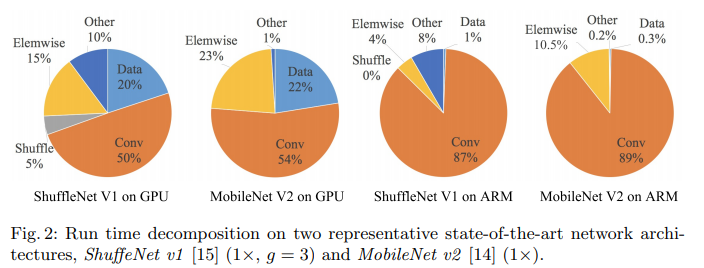

基于此，文章提出了4个原则：<br/>
1）$输入与输出维度相同可以保证最小的MAC。对于1x1卷积来说，输入维度为c_1,输出维度为\\c_2，h,w为输出特征图尺寸，则MAC=hw(c_1+c_2) + c_1c_2，根据基本不等式（mean value \\inequality），MAC >= 2\sqrt(hwB) + \frac{B}{hw}。因此，MAC在输入与输出维度相等的时\\候达到下界。$<br/>
2）$过多的组卷积增加了MAC。对于1x1的组卷积，MAC = hw(c_1 + c_2) + \frac{c_1c_2}{g} = \\hwc_1 + \frac{Bg}{c_1} + \frac{B}{hw}，其中B=hwc_1c_2/g，是FLOPs。可以看出，在输入\\特征尺寸c_1*h*w、计算量B固定的情况下，MAC随着group数量增多而增大。$<br/>
3）$网络碎片减少并行程度。在inception模块中，卷积尺寸不统一，有3x3的，1x1的，因此此类\\模块并行度不高。$<br/>
4）$Element-wise操作不可忽略。元素级操作如ReLU、AddTensor、AddBias等操作MAC较大，\\因此不能忽略。$

因此，我们的模型有如下指导原则：1)用平衡的卷积（equal channel width）；2)当心组卷积的耗时;3)减少碎片化；4）减少元素级操作。

下图中a)与b)是shufflenetV1两个标准模块，a)不需要降维，b)需要降维。这两个模块违反我们提出的原则，如果组卷积过多等。因此我们提出一个channel split操作，如下图(c)所示。将channel为c的输入根据channel分为两个分支，一个分支channel数为c’，另一个分支channel数为c-c’，在实现时一般用c’ = c/2。一个分支被送入后续卷积层，另一个分支作identity map。为了减少元素级操作，两个分支作concat操作。Channel split天然的有分组，因此后续可以添加channel shuffle操作来使组之间进行交流。<br/>
下采样版本的shufflenet见下图(d)。移除了channel split操作，而是做了一个copy，因此也是相当于有两个分组。
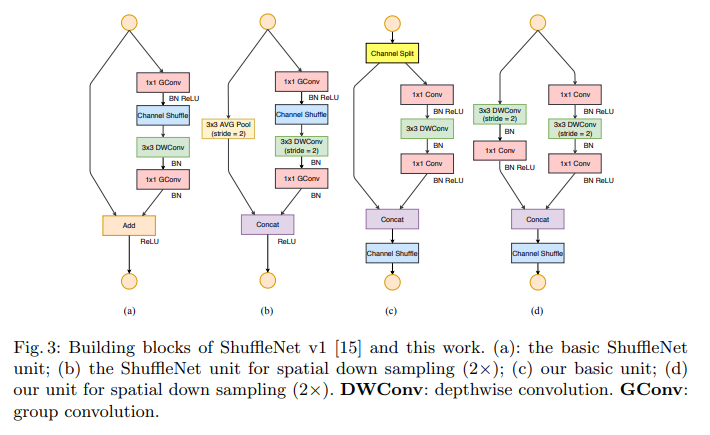

下表为shufflenetV2的整体结构。基于表5中的channel数量，我们用0.5x，1.0x来标记具有不同channel数量的网络结构。如shufflenetV2 0.5x表示，下表中通道数减少一半。
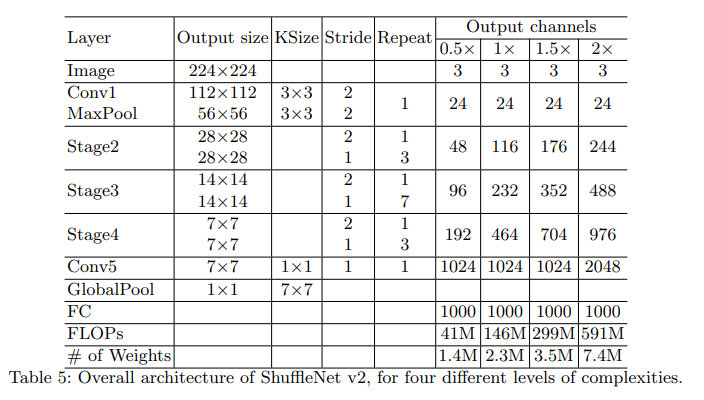

shufflenetV2不仅高效，而且准确。原因包括以下两点：1）高效的结构允许加入更多层与更多channel，将网络做深做宽。2)一半特征直接绕过模块，直接与输出相加，这个是一种特征重用，类似于densenet.